# Data Managment

### 1. Load the dataset and preprocess the images

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [14]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 1.6 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [17]:
data_dir = "../input/forest-fire-images/Data"
categories = ["Fire", "Non_Fire"]
img_size = 128

def create_data(data_dir, categories):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                if img_array is None:
#                     print(f"Could not read the image: {os.path.join(path, img)}")
                    continue
                
                img_resized = cv2.resize(img_array, (img_size, img_size))
                data.append([img_resized, class_num])
            except Exception as e:
                print(e)
    return data

train_data_dir = os.path.join(data_dir, "Train_Data")
test_data_dir = os.path.join(data_dir, "Test_Data")

train_data = create_data(train_data_dir, categories)
test_data = create_data(test_data_dir, categories)

### 3. Split the data into training and testing sets**

In [19]:
X_train, y_train = [], []
for features, label in train_data:
    X_train.append(features)
    y_train.append(label)

X_test, y_test = [], []
for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

    
X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)


# Blue and red channels were swapped, so changing their places back
X_train = X_train[:,:, :, [2, 1, 0]]
X_test = X_test[:,:, :, [2, 1, 0]]

### 4. Normalize the data**

In [20]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### 5. Data augmentation**

### Images before augmentation

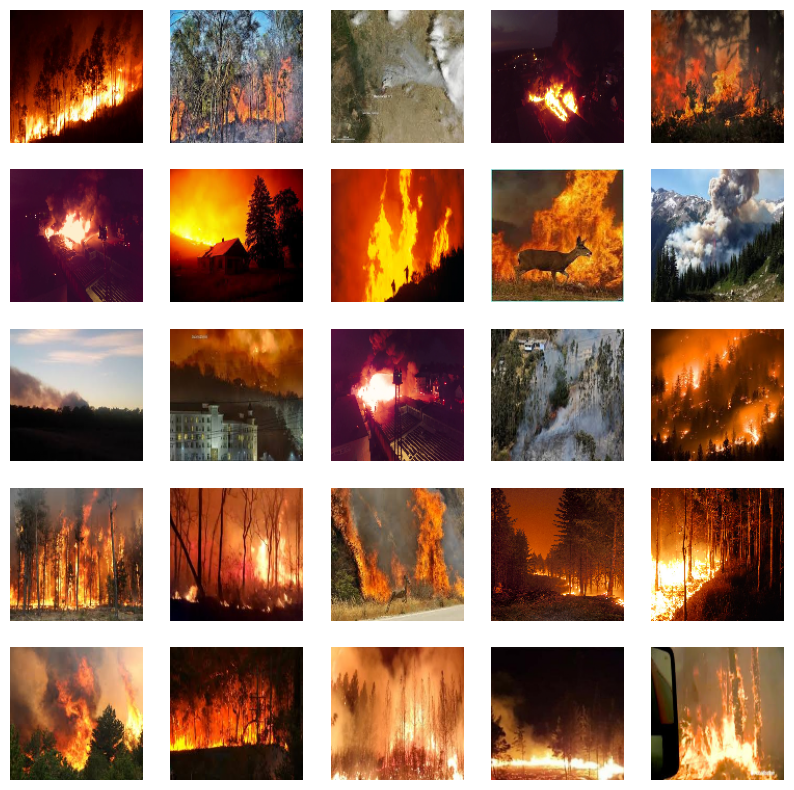

In [21]:
num_rows = 5
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < X_train.shape[0]:
        ax.imshow(X_train[i])
    ax.axis('off')
plt.show()

In [23]:
def augment_images(X_train, y_train):

    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    X_train_augmented = []
    y_train_augmented = []

    datagen.fit(X_train)

    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train)):
        X_train_augmented.extend(X_batch)
        y_train_augmented.extend(y_batch)
        break

    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)

    X_train_combined = np.concatenate((X_train, X_train_augmented), axis=0)
    y_train_combined = np.concatenate((y_train, y_train_augmented), axis=0)

    return X_train_combined, y_train_combined

X_train, y_train = augment_images(X_train, y_train)

### Images after augmentation

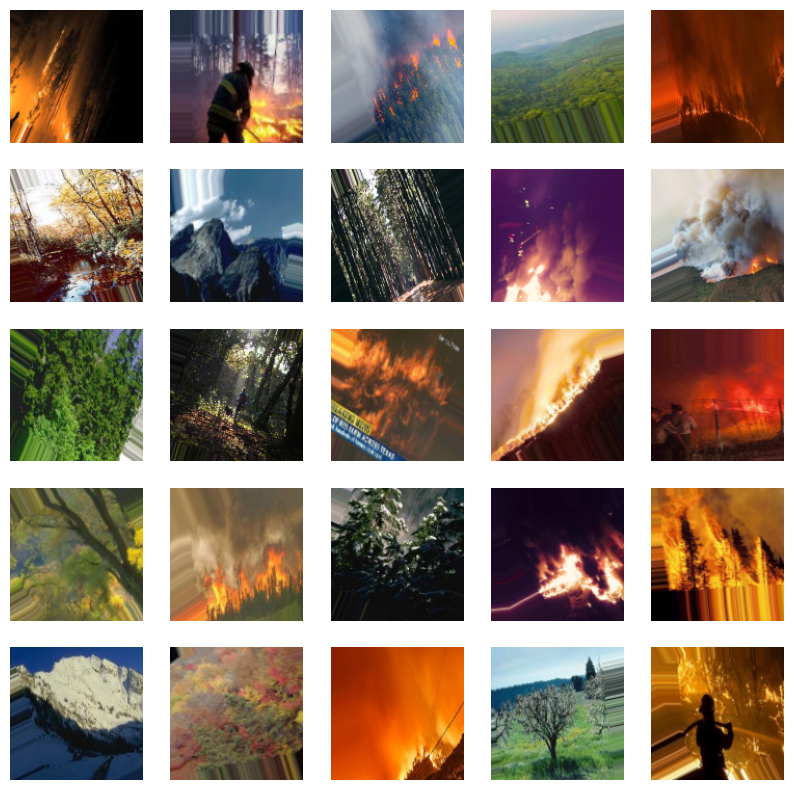

In [24]:
num_rows = 5
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < X_train.shape[0]:
        ax.imshow(X_train[X_train.shape[0]//2 + i])
    ax.axis('off')
plt.show()

# Modeling

In [30]:
X_train_flattened = X_train.reshape(X_train.shape[0],-1)
X_test_flattened = X_test.reshape(X_test.shape[0],-1)

In [32]:
n_components = 50

pca = PCA(n_components=n_components)
pca.fit(X_train_flattened)

X_train_pca = pca.transform(X_train_flattened)
X_test_pca = pca.transform(X_test_flattened)

# Logistic Regression

In [33]:
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_pca, y_train)

y_pred = log_reg.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1-score: {:.4f}'.format(f1))

Accuracy: 0.7600
Precision: 0.7407
Recall: 0.8000
F1-score: 0.7692


# XGBoost

In [34]:
dtrain = xgb.DMatrix(X_train_pca, label=y_train)
dtest = xgb.DMatrix(X_test_pca, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'gamma': 1.0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1
}

num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

y_pred = xgb_model.predict(dtest)
y_pred_bin = [1 if p >= 0.5 else 0 for p in y_pred]

acc = accuracy_score(y_test, y_pred_bin)
prec = precision_score(y_test, y_pred_bin)
rec = recall_score(y_test, y_pred_bin)
f1 = f1_score(y_test, y_pred_bin)

print('Accuracy: {:.4f}'.format(acc))
print('Precision: {:.4f}'.format(prec))
print('Recall: {:.4f}'.format(rec))
print('F1 score: {:.4f}'.format(f1))

Accuracy: 0.8400
Precision: 0.8148
Recall: 0.8800
F1 score: 0.8462


# CNN

### 6. Create the model**

In [35]:
model = Sequential()

conv_sizes = [16,32,64,128]
kernel_sizes = [5,3,3,3]


model.add(Input(shape=(img_size, img_size, 3)))

for i in range(len(conv_sizes)):
    
    model.add(Conv2D(conv_sizes[i], (kernel_sizes[i], kernel_sizes[i])))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 16)      1216      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 124, 124, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 32)       1

### 7. Train the model**

In [36]:
epochs = 7
batch_size = 32

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/7
461/461 [==============================] - 57s 120ms/step - loss: 0.3072 - accuracy: 0.8979 - val_loss: 0.3350 - val_accuracy: 0.8810
Epoch 2/7
461/461 [==============================] - 54s 116ms/step - loss: 0.1833 - accuracy: 0.9390 - val_loss: 0.1489 - val_accuracy: 0.9490
Epoch 3/7
461/461 [==============================] - 54s 116ms/step - loss: 0.1519 - accuracy: 0.9474 - val_loss: 0.1607 - val_accuracy: 0.9466
Epoch 4/7
461/461 [==============================] - 54s 116ms/step - loss: 0.1370 - accuracy: 0.9543 - val_loss: 0.1530 - val_accuracy: 0.9374
Epoch 5/7
461/461 [==============================] - 54s 117ms/step - loss: 0.1230 - accuracy: 0.9582 - val_loss: 0.2612 - val_accuracy: 0.9187
Epoch 6/7
461/461 [==============================] - 54s 116ms/step - loss: 0.1246 - accuracy: 0.9595 - val_loss: 0.1186 - val_accuracy: 0.9563
Epoch 7/7
461/461 [==============================] - 54s 117ms/step - loss: 0.1072 - accuracy: 0.9645 - val_loss: 0.1605 - val_accuracy:

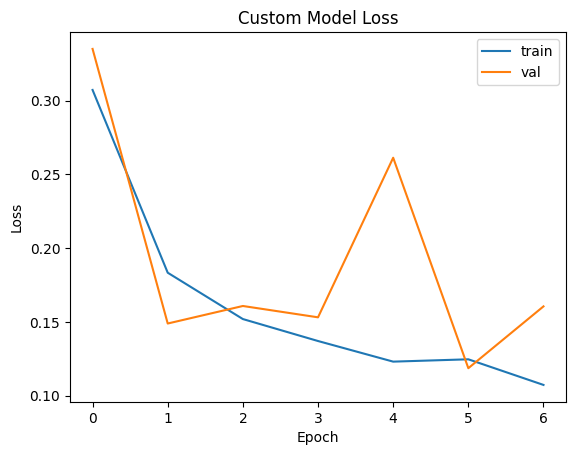

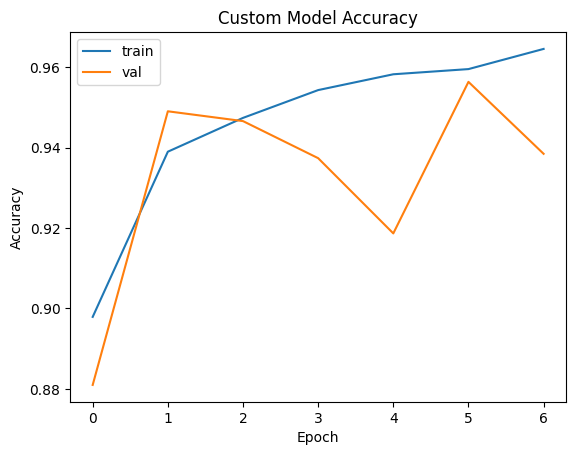

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Custom Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Custom Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### 8. Evaluate the model**

2/2 [==============================] - 0s 17ms/step - loss: 0.1676 - accuracy: 0.9400
Test accuracy: 0.9399999976158142
2/2 [==============================] - 0s 14ms/step


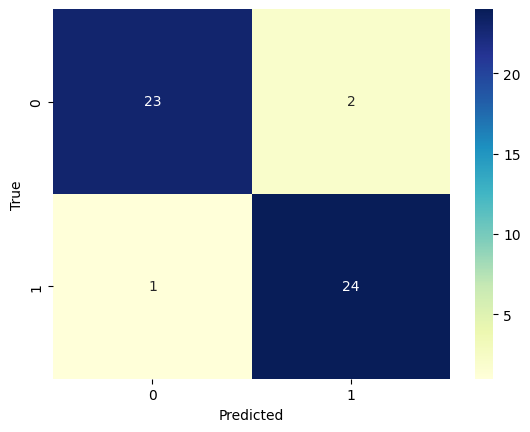

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.92      0.96      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



In [40]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred_classes))

### 9. Visualizing sample images from the dataset**

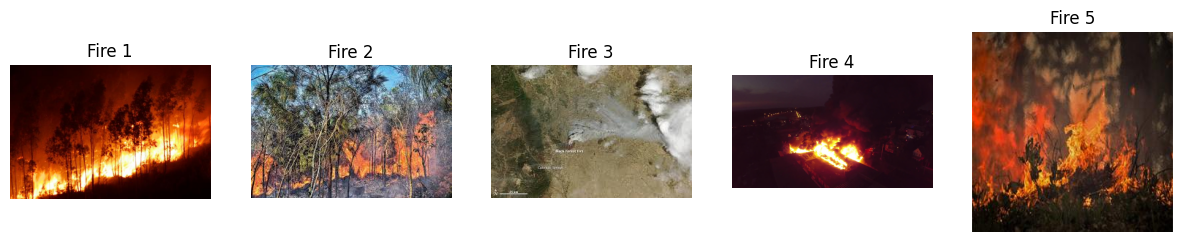

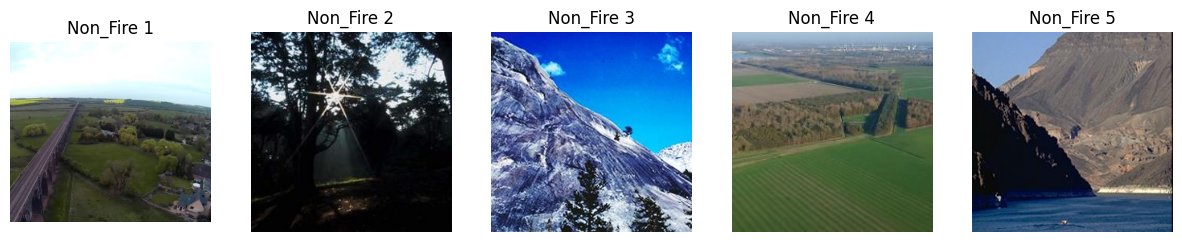

In [41]:
import matplotlib.pyplot as plt

def show_images(data_dir, category, num_images=5):
    path = os.path.join(data_dir, category)
    image_files = os.listdir(path)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    displayed_images = 0
    for image_file in image_files:
        if displayed_images >= num_images:
            break

        img = cv2.imread(os.path.join(path, image_file))
        
        if img is None:
            print(f"Unable to load image {image_file}. Skipping...")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[displayed_images].imshow(img)
        axes[displayed_images].set_title(f"{category} {displayed_images + 1}")
        axes[displayed_images].axis("off")
        displayed_images += 1

    plt.show()

show_images(train_data_dir, "Fire")
show_images(train_data_dir, "Non_Fire")

###**10. Save the model for future use**

In [42]:
model.save("forest_fire_classifier.h5")

## Transfer Learning

#### MobileNetV2

In [43]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size,img_size,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalAveragePooling2D(),
                              tf.keras.layers.Dense(1024, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.00008),
                loss = "binary_crossentropy",
                metrics=["accuracy"])


9406464/9406464 [==============================] - 0s 0us/step


In [44]:
history1 = model.fit(X_train,y_train,epochs = 10,batch_size=32, validation_split = 0.2)

Epoch 1/10
461/461 [==============================] - 50s 102ms/step - loss: 0.1551 - accuracy: 0.9432 - val_loss: 0.1197 - val_accuracy: 0.9577
Epoch 2/10
461/461 [==============================] - 47s 101ms/step - loss: 0.0827 - accuracy: 0.9723 - val_loss: 0.1044 - val_accuracy: 0.9618
Epoch 3/10
461/461 [==============================] - 47s 101ms/step - loss: 0.0644 - accuracy: 0.9793 - val_loss: 0.1012 - val_accuracy: 0.9623
Epoch 4/10
461/461 [==============================] - 46s 100ms/step - loss: 0.0515 - accuracy: 0.9841 - val_loss: 0.0911 - val_accuracy: 0.9672
Epoch 5/10
461/461 [==============================] - 47s 102ms/step - loss: 0.0410 - accuracy: 0.9876 - val_loss: 0.1008 - val_accuracy: 0.9626
Epoch 6/10
461/461 [==============================] - 46s 100ms/step - loss: 0.0319 - accuracy: 0.9913 - val_loss: 0.0852 - val_accuracy: 0.9699
Epoch 7/10
461/461 [==============================] - 47s 102ms/step - loss: 0.0258 - accuracy: 0.9939 - val_loss: 0.0879 - val_ac

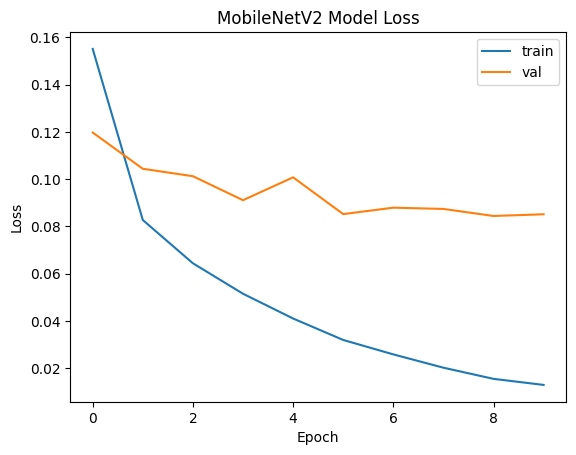

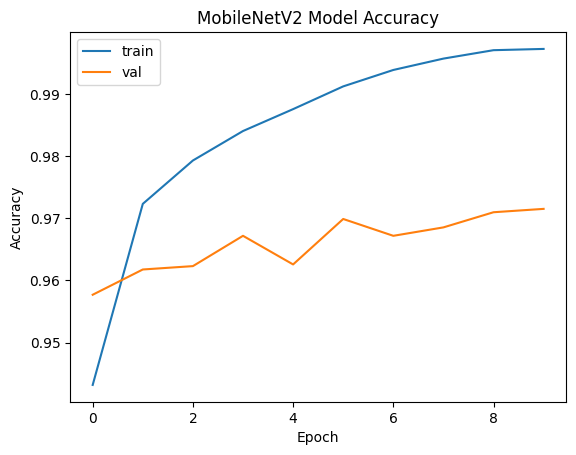

In [45]:
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='val')
plt.title('MobileNetV2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='val')
plt.title('MobileNetV2 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

2/2 [==============================] - 0s 47ms/step - loss: 0.1290 - accuracy: 0.9200
Test accuracy: 0.9200000166893005
2/2 [==============================] - 1s 44ms/step


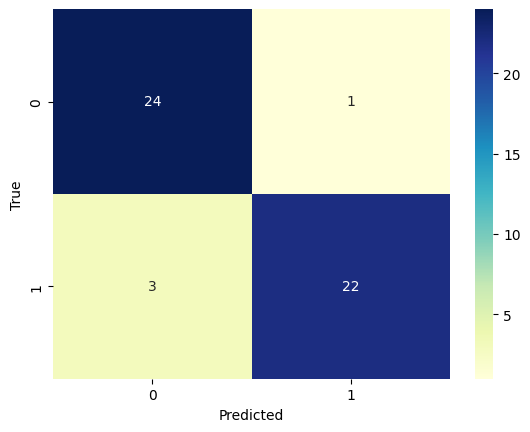

              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



In [46]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred_classes))

#### InceptionResNetV2

In [47]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(img_size,img_size,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=["accuracy"])


219055592/219055592 [==============================] - 1s 0us/step


In [48]:
history2 = model.fit(X_train,y_train,epochs = 5,batch_size=32, validation_split = 0.2)

Epoch 1/5
461/461 [==============================] - 171s 348ms/step - loss: 0.2009 - accuracy: 0.9265 - val_loss: 0.1590 - val_accuracy: 0.9433
Epoch 2/5
461/461 [==============================] - 155s 337ms/step - loss: 0.1240 - accuracy: 0.9587 - val_loss: 0.1513 - val_accuracy: 0.9439
Epoch 3/5
461/461 [==============================] - 155s 336ms/step - loss: 0.0950 - accuracy: 0.9681 - val_loss: 0.1368 - val_accuracy: 0.9525
Epoch 4/5
461/461 [==============================] - 155s 337ms/step - loss: 0.0739 - accuracy: 0.9760 - val_loss: 0.1371 - val_accuracy: 0.9539
Epoch 5/5
461/461 [==============================] - 155s 336ms/step - loss: 0.0580 - accuracy: 0.9816 - val_loss: 0.1354 - val_accuracy: 0.9574


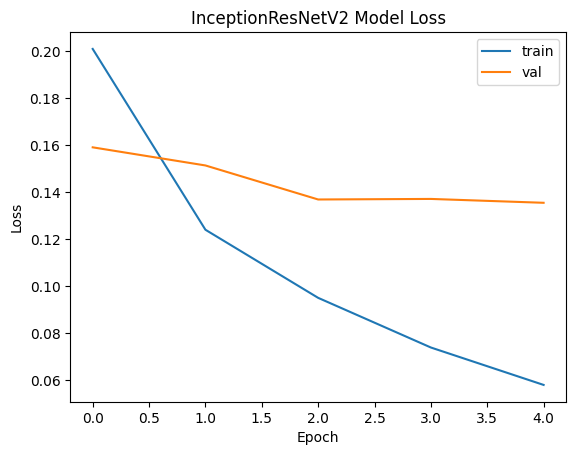

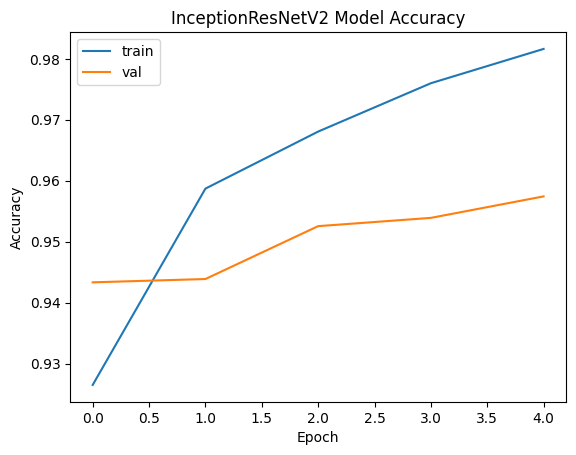

In [49]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.title('InceptionResNetV2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='val')
plt.title('InceptionResNetV2 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

2/2 [==============================] - 0s 208ms/step - loss: 0.1191 - accuracy: 0.9600
Test accuracy: 0.9599999785423279
2/2 [==============================] - 3s 204ms/step


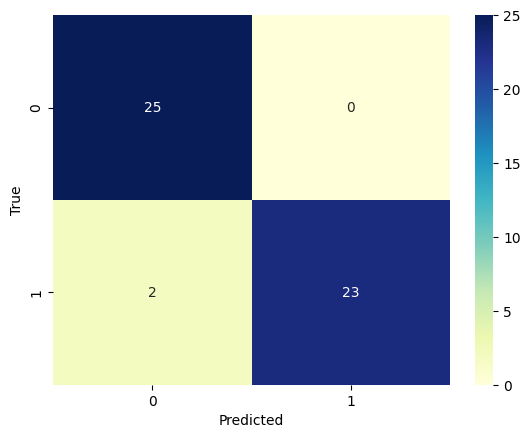

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        25
           1       1.00      0.92      0.96        25

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



In [50]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred_classes))